In [2]:
import os

downloads_path = os.path.expanduser("~/Downloads/Fleet-Sustainment-HVAC-Project")
os.chdir(downloads_path)

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

hvacdata = pd.read_csv('Archive/2. ProcessedData/dataset.csv')


/var/folders/9f/3yz89nb525nczbywh5dl11kh0000gn/T/ipykernel_24395/3174971943.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  hvacdata = pd.read_csv('Archive/2. ProcessedData/dataset.csv')


In [4]:
print(hvacdata.columns.tolist())

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


print(hvacdata.head(5))



['uic', 'job_seq', 'apl', 'cause_code', 'cdm_rin', 'csmp_narrative_summary', 'date_closing', 'date_maintenance_action', 'deferral_reason_code', 'due_date', 'eic', 'equipment_nomenclature', 'eswbs_opening', 'identification_number_closing', 'iuc_screening_code', 'location', 'mhc', 'mho', 'mhr', 'priority_code', 'safety_code', 'status_code', 'tycom_screening_code', 'type_availability_code', 'type_of_maintenance_action', 'when_discovered_code', 'work_center', 'total_ima_man_hours', 'total_ship_force_man_hours', 'total_replacement_cost', 'total_repair_replacement_cost', 'def_narrative', 'nondef_narrative', 'closing_narrative', 'ima_narrative', 'total_material_cost', 'opening_ship_system', 'closing_ship_system', 'job_status', 'days_open', 'action_taken', 'intermediate_unit_commander_screening', 'priority', 'component_status', 'type_of_availability_needed', 'tycom_screening', 'when_discovered', 'cause', 'deferral_reason', 'feasible_with_ship_inventory', 'feasible_with_additional_dla_inventory

In [5]:
hvacdata['date_maintenance_action'] = pd.to_datetime(hvacdata['date_maintenance_action'], errors='coerce')

# group by `ship` to find the earliest date
first_maintenance_dates = (
    hvacdata.groupby('ship')['date_maintenance_action']
    .min()
    .reset_index()
    .rename(columns={'date_maintenance_action': 'first_maintenance_date'})
)

print(first_maintenance_dates)


     ship first_maintenance_date
0   CVN68             2017-11-02
1   CVN69             2017-11-01
2   CVN70             2017-11-01
3   CVN71             2017-11-04
4   CVN72             2017-11-01
5   CVN73             2017-11-02
6   CVN74             2017-11-01
7   CVN75             2017-11-02
8   CVN76             2017-11-01
9   CVN77             2017-11-01
10  CVN78             2017-11-01


In [6]:
hvacdata = hvacdata.merge(first_maintenance_dates, on='ship', how='left')


In [7]:
# column for calendar month
hvacdata['calendar_month'] = hvacdata['date_maintenance_action'].dt.to_period('M')


In [8]:
# calculate time since start of maintenance jobs

hvacdata['months_since_first_maintenance'] = (
    (hvacdata['date_maintenance_action'] - hvacdata['first_maintenance_date']) / np.timedelta64(1, 'M')
)


hvacdata['months_since_first_maintenance'] = (
    hvacdata['months_since_first_maintenance']
    .round()
    .astype('Int64')
)

hvacdata = hvacdata[hvacdata['ship'].notna()]


In [9]:
print(hvacdata[['ship', 'date_maintenance_action', 'first_maintenance_date', 'months_since_first_maintenance']].head())

    ship date_maintenance_action first_maintenance_date  \
1  CVN69              2018-07-16             2017-11-01   
2  CVN69              2018-07-16             2017-11-01   
3  CVN77              2018-07-16             2017-11-01   
4  CVN75              2018-05-11             2017-11-02   
5  CVN75              2018-05-11             2017-11-02   

   months_since_first_maintenance  
1                               8  
2                               8  
3                               8  
4                               6  
5                               6  


In [10]:
print(hvacdata.columns.tolist())


['uic', 'job_seq', 'apl', 'cause_code', 'cdm_rin', 'csmp_narrative_summary', 'date_closing', 'date_maintenance_action', 'deferral_reason_code', 'due_date', 'eic', 'equipment_nomenclature', 'eswbs_opening', 'identification_number_closing', 'iuc_screening_code', 'location', 'mhc', 'mho', 'mhr', 'priority_code', 'safety_code', 'status_code', 'tycom_screening_code', 'type_availability_code', 'type_of_maintenance_action', 'when_discovered_code', 'work_center', 'total_ima_man_hours', 'total_ship_force_man_hours', 'total_replacement_cost', 'total_repair_replacement_cost', 'def_narrative', 'nondef_narrative', 'closing_narrative', 'ima_narrative', 'total_material_cost', 'opening_ship_system', 'closing_ship_system', 'job_status', 'days_open', 'action_taken', 'intermediate_unit_commander_screening', 'priority', 'component_status', 'type_of_availability_needed', 'tycom_screening', 'when_discovered', 'cause', 'deferral_reason', 'feasible_with_ship_inventory', 'feasible_with_additional_dla_inventory

In [11]:
hvacdata['computed_total_material_cost'] = hvacdata['unit_price'] * hvacdata['quantity']




In [12]:
job_summary = (
    hvacdata.groupby(['ship', 'months_since_first_maintenance'])
    .agg(
        num_jobs=('ship', 'count'),
        total_material_cost=('computed_total_material_cost', 'sum')
    )
    .reset_index()
)

print(job_summary.head(10))


    ship  months_since_first_maintenance  num_jobs  total_material_cost
0  CVN68                               0       152            1184.8200
1  CVN68                               1        88            5883.6300
2  CVN68                               2       166           22249.2375
3  CVN68                               3       422           51977.9175
4  CVN68                               4       300            9381.6250
5  CVN68                               5       164           41598.1875
6  CVN68                               6       278            8723.3850
7  CVN68                               7       194           28921.8525
8  CVN68                               8       112            4791.1425
9  CVN68                               9       114            7569.3500


In [13]:
# groups data by ship, months_since_rcoh_start, and part


monthly_part_summary = (
    hvacdata.groupby(['ship', 'calendar_month', 'niin_nomenclature'])
    .agg(
        total_part_quantity=('quantity', 'sum'),
        num_jobs=('job_status', 'count'),
        total_material_cost=('computed_total_material_cost', 'sum')
    )
    .reset_index()
)


print(monthly_part_summary.head(20))


     ship calendar_month    niin_nomenclature  total_part_quantity  num_jobs  \
0   CVN68        2017-11               BELT,V                  4.0         2   
1   CVN68        2017-11   CONTACTOR,MAGNETIC                  2.0         2   
2   CVN68        2017-11   FILTER ELEMENT,AIR                160.0       142   
3   CVN68        2017-11  RELAY,ELECTROMAGNET                  2.0         2   
4   CVN68        2017-12   FILTER ELEMENT,AIR                 12.0        10   
5   CVN68        2017-12  HEATING ELEMENT,ELE                  6.0         6   
6   CVN68        2017-12   PARTS KIT,PRESSURE                  2.0         2   
7   CVN68        2017-12  PARTS KIT,REGULATIN                  2.0         2   
8   CVN68        2017-12  RELAY,ELECTROMAGNET                  2.0         2   
9   CVN68        2017-12                 RING                  4.0         4   
10  CVN68        2017-12       RING,RETAINING                  4.0         4   
11  CVN68        2017-12    TRANSFORMER,

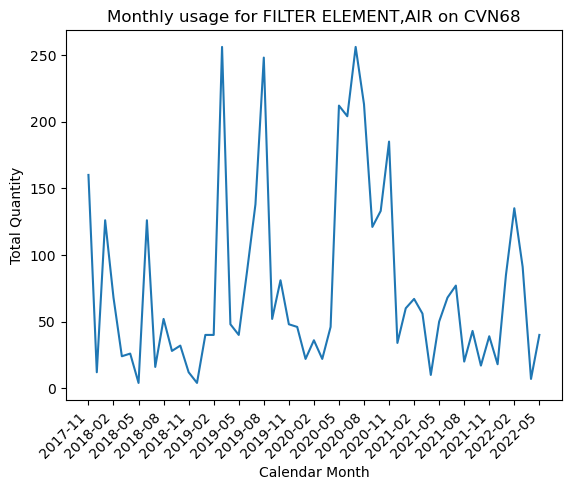

In [14]:
import matplotlib.pyplot as plt

part = 'FILTER ELEMENT,AIR'
ship = 'CVN68'

part_data = monthly_part_summary[
    (monthly_part_summary['niin_nomenclature'] == part) &
    (monthly_part_summary['ship'] == ship)
]

plt.plot(part_data['calendar_month'].astype(str), part_data['total_part_quantity'])
plt.title(f"Monthly usage for {part} on {ship}")
plt.xlabel('Calendar Month')
plt.ylabel('Total Quantity')

# every 3rd month for readability
plt.xticks(
    ticks=range(0, len(part_data['calendar_month']), 3),
    labels=part_data['calendar_month'].astype(str)[::3],
    rotation=45,
    ha='right'
)

plt.show()


In [15]:
# some feature ideas that could go into model: num_jobs (more jobs = more parts), maintenace_duration (if jobs are taking longer, maybe more parts are needed), ship_age (older ships may need more replacement parts), months_since_rcoh_start, etc.

     calendar_month  total_part_quantity  rolling_avg_quantity
2           2017-11                160.0                   NaN
4           2017-12                 12.0                   NaN
17          2018-01                126.0             99.333333
27          2018-02                 68.0             68.666667
38          2018-03                 24.0             72.666667
47          2018-04                 26.0             39.333333
61          2018-05                  4.0             18.000000
74          2018-06                126.0             52.000000
92          2018-07                 16.0             48.666667
100         2018-08                 52.0             64.666667
112         2018-09                 28.0             32.000000
123         2018-10                 32.0             37.333333
131         2018-11                 12.0             24.000000
138         2018-12                  4.0             16.000000
147         2019-01                 40.0             18

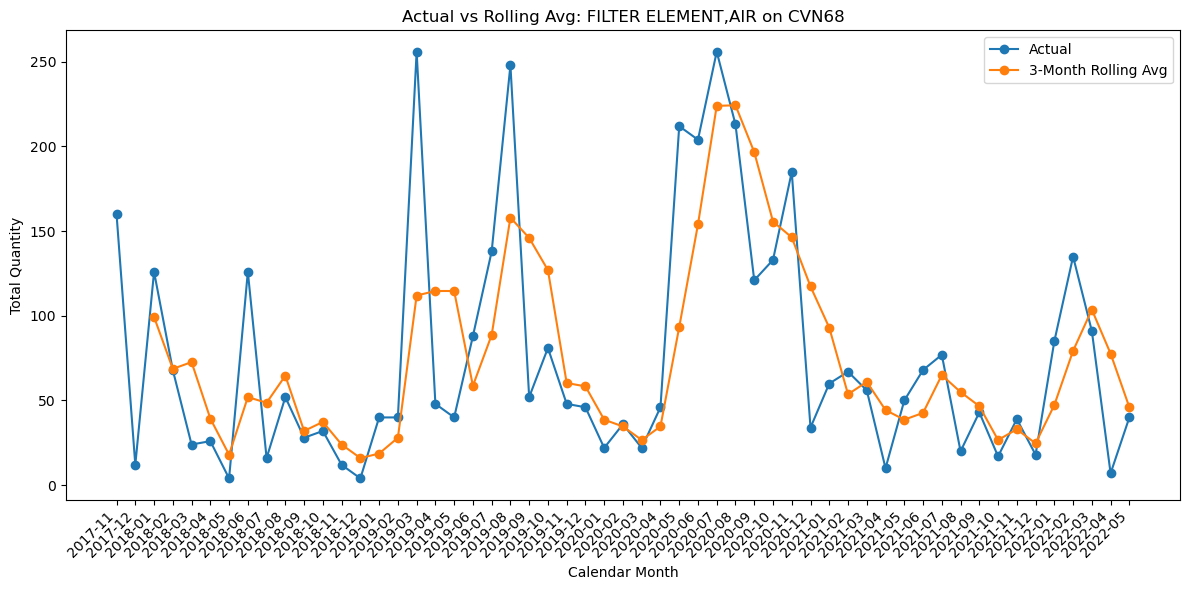

In [16]:
# rolling average column for quantity, smooth demand trend for better forecasting insight
# mean of current month and the previous 2 months
part_data = part_data.sort_values('calendar_month')
part_data['rolling_avg_quantity'] = part_data['total_part_quantity'].rolling(window=3).mean()

print(part_data[['calendar_month', 'total_part_quantity', 'rolling_avg_quantity']])


plt.figure(figsize=(12, 6))
plt.plot(part_data['calendar_month'].astype(str), part_data['total_part_quantity'], marker='o', label='Actual')
plt.plot(part_data['calendar_month'].astype(str), part_data['rolling_avg_quantity'], marker='o', label='3-Month Rolling Avg')
plt.title(f'Actual vs Rolling Avg: {part} on {ship}')
plt.xlabel('Calendar Month')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# test model


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# calendar_month sorted
part_data = part_data.sort_values('calendar_month').reset_index(drop=True)

# convert calendar_month to an integer index for regression
part_data['month_index'] = np.arange(len(part_data))

X = part_data[['month_index']]
y = part_data['total_part_quantity']


In [18]:
# last 5 months for testing

X_train, X_test = X[:-3], X[-3:]
y_train, y_test = y[:-3], y[-3:]


model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [19]:
y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# actual vs predicted
results = pd.DataFrame({
    'calendar_month': part_data['calendar_month'][-3:].astype(str),
    'actual': y_test,
    'predicted': y_pred
})
print(results)



Mean Squared Error: 2755.82
   calendar_month  actual  predicted
52        2022-03    91.0  85.122172
53        2022-04     7.0  85.399641
54        2022-05    40.0  85.677111


In [20]:
# Prophet Model
# models seasonality (certain months consistently see more usage?) trends automatically
# identifies general trend (are quantities increasing/decresing over months?)


import pandas as pd

part = 'FILTER ELEMENT,AIR'
ship = 'CVN68'

# summary table for this filter & cvn 68
part_data = monthly_part_summary[
    (monthly_part_summary['niin_nomenclature'] == part) &
    (monthly_part_summary['ship'] == ship)
].copy()

# date, Prophet takes in timestamp format
part_data['ds'] = part_data['calendar_month'].apply(lambda x: x.to_timestamp())

# predicting the number of parts needed
part_data['y'] = part_data['total_part_quantity']

# these are the only two required columns for prophet
prophet_data = part_data[['ds', 'y']].sort_values('ds')

print(prophet_data.tail())


             ds      y
1068 2022-01-01   85.0
1088 2022-02-01  135.0
1122 2022-03-01   91.0
1159 2022-04-01    7.0
1175 2022-05-01   40.0


In [42]:
from prophet import Prophet

# hold out last 6 months for training/testing
train = prophet_data.iloc[:-6]
test = prophet_data.iloc[-6:]

# prophet model
model = Prophet()

# fit model to part_data
model.fit(train)

print(test)



15:08:09 - cmdstanpy - INFO - Chain [1] start processing
15:08:09 - cmdstanpy - INFO - Chain [1] done processing


             ds      y
1034 2021-12-01   18.0
1068 2022-01-01   85.0
1088 2022-02-01  135.0
1122 2022-03-01   91.0
1159 2022-04-01    7.0
1175 2022-05-01   40.0


In [47]:
# future dataframe, extend dates to predict 6 months ahead
future = model.make_future_dataframe(periods=6, freq='MS') # MS = month-start
forecast = model.predict(future)


In [48]:
forecast_eval = forecast[['ds', 'yhat']].merge(
    prophet_data[['ds', 'y']], on='ds', how='left'
)

print(forecast_eval.tail(30))


           ds        yhat      y
25 2019-12-01   40.081408   46.0
26 2020-01-01   32.057742   22.0
27 2020-02-01   26.828550   36.0
28 2020-03-01   -2.479484   22.0
29 2020-04-01   26.195450   46.0
30 2020-05-01  144.897069  212.0
31 2020-06-01  136.662810  204.0
32 2020-07-01  146.035339  256.0
33 2020-08-01   70.810284  213.0
34 2020-09-01   50.586057  121.0
35 2020-10-01   50.377952  133.0
36 2020-11-01  136.344345  185.0
37 2020-12-01   12.027690   34.0
38 2021-01-01   95.882799   60.0
39 2021-02-01   83.610896   67.0
40 2021-03-01   61.306537   56.0
41 2021-04-01   33.871010   10.0
42 2021-05-01  102.020260   50.0
43 2021-06-01  128.608754   68.0
44 2021-07-01  131.592806   77.0
45 2021-08-01  114.535855   20.0
46 2021-09-01   60.299324   43.0
47 2021-10-01   63.667499   17.0
48 2021-11-01  105.773245   39.0
49 2021-12-01   23.717053   18.0
50 2022-01-01   77.024019   85.0
51 2022-02-01   66.036477  135.0
52 2022-03-01  125.054561   91.0
53 2022-04-01   40.010138    7.0
54 2022-05